# All imports

In [17]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# More Imports for ML stuff
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Helper classes / Methods

In [18]:
# Loads and prepares the data.
# Data can be accessed over class variables: train_input_FOCI, train_target_FOCI, validation_input_FOCI...
# Unprocessed data is saved. When seq_length or feature_list are None, they are not used.
# Data is processed to have 0 mean and 1 std.
# possible_features variable contains list with all feature names, even those that have not been selected.
# For lead_time = 0, the sequences currently DO NOT contain previous prec_sahel values.
# flatten_seq = False means that each sample consits of the arrays for each time step (e.g. [t1, t2, ...])
# flatten_seq = True means that each sample contains all the values of the time steps. (array containing values vs array containing arrays of values)
class Data:
  # Split = [train,validation, test], lead_time >= 0, seq_length > 0 or None, feature_list None or list of feature names
  def __init__(self, split = [0.9, 0.0, 0.1], lead_time = 0, seq_length=None, flatten_seq=False, feature_list=None):
    # Variables
    self.possible_features = [] # Filled later on to track all possible features before selection
    self.current_features = [] # Filled later to track selected features
    self.__data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
    )

    # Load the data
    FOCI, CESM = self.__load_data()

    # Split into input and target
    input_FOCI, target_FOCI = self.__get_input_target(FOCI, lead_time)
    input_CESM, target_CESM = self.__get_input_target(CESM, lead_time)

    # Save possible features that can be selected
    self.possible_features = list(input_FOCI.columns)

    # Select features if any are set
    input_FOCI = input_FOCI if feature_list is None else input_FOCI[feature_list]
    input_CESM = input_CESM if feature_list is None else input_CESM[feature_list]

    # Save selected features
    self.current_features = list(input_FOCI.columns)

    # Split into train, validation and test, based on split percentage given
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__get_train_validation_test(input_FOCI, split)
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__get_train_validation_test(target_FOCI, split)

    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__get_train_validation_test(input_CESM, split)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__get_train_validation_test(target_CESM, split)

    # Fit standardscaler on trainings data and then scale train, validation and test input with it to obtain 0 mean and 1 std
    # Returned values are numpy arrays
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__scale_data(self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI)
    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__scale_data(self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM)

    # Do the same with the target data
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__scale_data(self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__scale_data(self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM)

    # Turn target arrays into 1D arrays, reshape only if array actually exists
    # otherwise an error would be thrown.
    if len(self.train_target_FOCI) > 0:
      self.train_target_FOCI = self.train_target_FOCI.reshape(-1)
      self.train_target_CESM = self.train_target_CESM.reshape(-1)
    if len(self.validation_target_FOCI) > 0:
      self.validation_target_FOCI = self.validation_target_FOCI.reshape(-1)
      self.validation_target_CESM = self.validation_target_CESM.reshape(-1)
    if len(self.test_target_FOCI) > 0:
      self.test_target_FOCI = self.test_target_FOCI.reshape(-1)
      self.test_target_CESM = self.test_target_CESM.reshape(-1)

    # Turn data into sequences consisting of seq_length timesteps
    if seq_length is not None:
      # Check for valid seq_length
      if seq_length <= 0:
        raise ValueError('seq_length has to be an integer > 0 or None but is{}'.format(seq_length))

      # Train FOCI
      if len(self.train_input_FOCI) > 0:
        self.train_input_FOCI, self.train_target_FOCI = self.__into_sequence(self.train_input_FOCI, self.train_target_FOCI, seq_length, flatten_seq)
      # Validation FOCI
      if len(self.validation_input_FOCI) > 0:
        self.validation_input_FOCI, self.validation_target_FOCI = self.__into_sequence(self.validation_input_FOCI, self.validation_target_FOCI, seq_length, flatten_seq)
      # Test FOCI
      if len(self.test_input_FOCI) > 0:
        self.test_input_FOCI, self.test_target_FOCI = self.__into_sequence(self.test_input_FOCI, self.test_target_FOCI, seq_length, flatten_seq)
      # Train CESM
      if len(self.train_input_CESM) > 0:
        self.train_input_CESM, self.train_target_CESM = self.__into_sequence(self.train_input_CESM, self.train_target_CESM, seq_length, flatten_seq)
      # Validation CESM
      if len(self.validation_input_CESM) > 0:
        self.validation_input_CESM, self.validation_target_CESM = self.__into_sequence(self.validation_input_CESM, self.validation_target_CESM, seq_length, flatten_seq)
      # Test CESM
      if len(self.test_input_CESM) > 0:
        self.test_input_CESM, self.test_target_CESM = self.__into_sequence(self.test_input_CESM, self.test_target_CESM, seq_length, flatten_seq)


  # Loads the data from url or disk, returns FOCI, CESM as pandas dataframes.
  def __load_data(self):
    # Check if data exists on disk, if so load from disk, otherwise from url
    if os.path.exists('climate_indices.csv'):
      climind = pd.read_csv('climate_indices.csv')
    else:
      climind = pd.read_csv(self.__data_url)
      # Save data to disk
      climind.to_csv('climate_indices.csv', index=False)

    # Split into FOCI and CESM
    climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]
    FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
    CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

    # Return them
    return FOCI, CESM

  # Takes the FOCI or CESM pandas dataframe and returns the input and target
  # Input and target depends on the lead_time, for lead_time >0 input contains
  # PREC_SAHEL of the current time step, for lead_time = 0 it does not.
  # lead_time determines how many months in advance the target is.
  def __get_input_target(self, data, lead_time):
    # Check if lead_time is vlaid
    if lead_time < 0:
      raise ValueError('lead_time has to have a value >= 0 but has value {}'.format(self.__lead_time))

    # Split into target and input, input has to omit the last lead_time elements or there would be no target for them
    target = data.loc[:,data.columns == 'PREC_SAHEL']
    input = data.loc[:,data.columns != 'PREC_SAHEL'] if lead_time == 0 else data[:-lead_time]

    # Adjust target for lead_time if needed
    if lead_time > 0:
      target = target[lead_time:]

    # Return input and target
    return input, target

  # Splits data based on the given split into train, validation and test
  # split = [train, validation, test] as decimal indicating percentage
  def __get_train_validation_test(self, data, split):
    # Check if split is valid
    if sum(split) != 1 or split[0] <= 0 or any(i < 0 for i in split):
      raise ValueError('Invalid split has been passed. Values can be negative, have to sum up to 1 and train has to be > 0')

    # Get number of samples for each split
    n_train = int(split[0] * len(data))
    n_val = int(split[1] * len(data))
    n_test = int(split[2] * len(data))  # Only used to check if there is a test set

    # Create the splits
    train = data[:n_train] if n_train > 0 else []
    val =  data[n_train:n_train+n_val] if n_val > 0 else []
    test = data[n_train+n_val:] if n_test > 0 else []

    # Return them
    return train, val, test

  # Scales the data to have mean of 0 and std of 1
  # only fits on the training input data
  def __scale_data(self, train, val, test):
    scaler = StandardScaler()
    scaler.fit(train)

    # Transform train, val, test input to have 0 mean and 1std
    # only perform transformation if set is non empty
    scaled_train = scaler.transform(train) if len(train) > 0 else []
    scaled_val = scaler.transform(val) if len(val) > 0 else []
    scaled_test = scaler.transform(test) if len(test) > 0 else []

    return scaled_train, scaled_val, scaled_test

  # Turns input into a sequence consisting of seq_length time steps
  # and selects i+seq_length-1 as the corresponding target index for the i'th sequence.
  def __into_sequence(self, input, target, seq_length, flatten_seq):
    input_seq = np.array([input[i:i+seq_length] for i in range(len(input)-seq_length)])
    target_seq = np.array([target[i+seq_length-1] for i in range(len(target)-seq_length)])

    # Flatten sample containing the sequences if wanted (sample = [t_0, t_1,...] with t_0 = [feature_1, feature_2,...])
    if flatten_seq:
      input_seq = [seq.reshape(-1) for seq in input_seq]

    return input_seq, target_seq

In [19]:
# Class used to store the data for pytorch
class RegressionDataset(Dataset):
    def __init__(self, input, target):
        self.input = torch.tensor(input, dtype=torch.float32)
        self.target = torch.tensor(target.reshape(-1,1), dtype=torch.float32)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.target[idx]
        return x, y

In [20]:
# Evalute a model using its made predictions and the expected ground truth
# todo: split into evaluation and visualisation
def evalute_predictions(predicted, ground_truth, text=''):
  mse = mean_squared_error(ground_truth, predicted)
  corr = np.corrcoef(ground_truth, predicted)[0,1]

  plt.scatter(ground_truth, predicted, label='MSE: {}\nCorr: {}'.format(mse, corr))
  x = np.linspace(*plt.xlim())
  plt.plot(x, x, linestyle='--', color='k', lw=2)

  plt.title(text)
  plt.xlabel('Target')
  plt.ylabel('Predicted')
  plt.legend()
  plt.show()

  return mse, corr

In [21]:
# Plots training and validation loss + adds a vertical line at lowest validation loss to show the selected model
def visualise_loss_history(training_loss_history, validation_loss_history, title='Training and Validation loss'):
  val, idx = min((val, idx) for (idx, val) in enumerate(validation_loss_history))
  plt.plot(training_loss_history, label='train_loss')
  plt.plot(validation_loss_history,label='val_loss')
  plt.axvline(x=idx, label='min val_loss', color='gray')
  plt.legend()
  plt.title(title)
  plt.show()

In [22]:
# Shows predicted values against target values
def visualise_predictions_against_targtes(predicted, target, title='Predictions vs Targets'):
  plt.figure(figsize=(20, 8))
  plt.bar(range(len(target)), target, label='Targets')
  plt.plot(predicted, label='Predictions', color='black')
  plt.legend()
  plt.title(title)
  plt.show()

In [23]:
# Trains pytorch models and returns their train/validation loss history.
# Uses early stopping by restoring the weights of the model with the lowest validation loss after all epochs.
# Uses MSE loss and Adam optimizer
# Expects the model, the dataloader for the training, as well as the dataloader for the validation data.
# epochs, and learning rate are adjustable.
# learning rate: 0.025
def train_pytorch_network(model, train_dataloader, val_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=0):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Used to track loss
  train_loss_history = []
  validation_loss_history = []

  # Used for early stopping
  lowest_validation_loss = float('inf')
  best_model_weights = None

  # Train the model
  for epoch in range(num_epochs):
    # Reset loss and prepare model for training
    train_loss = 0.0
    model.train()
    # Train the model on all batches
    for i, (inputs, targets) in enumerate(train_dataloader):
      optimizer.zero_grad()
      out = model(inputs)
      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Adjust train loss for number of samples
    train_loss = train_loss / len(train_dataloader)

    # Calculate validation loss
    val_loss = 0.0
    model.eval()
    for i, (inputs, targets) in enumerate(val_dataloader):
      out = model(inputs)
      loss = criterion(out, targets)
      val_loss += loss.item()

    # Adjust val loss for number of samples
    val_loss = val_loss / len(val_dataloader)

    # Save train and validation loss of current epoch
    train_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)

    # Save weights of the model with the best validation performance (early stopping)
    if val_loss <= lowest_validation_loss:
      best_model_weights = model.state_dict()

  # Restore the weights of the best model
  model.load_state_dict(best_model_weights)

  # Return loss history
  return train_loss_history, validation_loss_history

In [24]:
# Returns the predictions of the model for the given ground truth
def test_pytorch_network(model, input, target):
  dataset = RegressionDataset(input, target)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

  # Prepare model
  model.eval()

  # Predict for the given input
  predictions = []
  ground_truth = []

  for (inputs, targets) in dataloader:
    pred = model(inputs).flatten()
    pred = pred.detach().numpy()
    predictions.append(pred)

    gt = targets.flatten()
    gt = gt.numpy()
    ground_truth.append(gt)

  # Get predictions and gt as a flat array
  predictions = np.concatenate(predictions)
  ground_truth = np.concatenate(ground_truth)

  return predictions, ground_truth

In [25]:
# Trains and evaluates the model, expects train, val and test split > 0
def train_and_evaluate_model(model, data, num_epochs=200, learning_rate=0.001, weight_decay=0):
  # Save untrained weights of model
  weights = model.state_dict()

  # FOCI dataset
  train_data_FOCI = RegressionDataset(data.train_input_FOCI, data.train_target_FOCI)
  val_data_FOCI = RegressionDataset(data.validation_input_FOCI, data.validation_target_FOCI)
  test_data_FOCI = RegressionDataset(data.test_input_FOCI, data.test_target_FOCI)

  # CESM dataset
  train_data_CESM = RegressionDataset(data.train_input_CESM, data.train_target_CESM)
  val_data_CESM = RegressionDataset(data.validation_input_CESM, data.validation_target_CESM)
  test_data_CESM = RegressionDataset(data.test_input_CESM, data.test_target_CESM)

  # FOCI Dataloaders
  train_dataloader_FOCI = DataLoader(train_data_FOCI, batch_size=32, shuffle=True)
  val_dataloader_FOCI = DataLoader(val_data_FOCI, batch_size=32, shuffle=False)
  test_dataloader_FOCI = DataLoader(test_data_FOCI, batch_size=32, shuffle=False)

  # CESM Dataloaders
  train_dataloader_CESM = DataLoader(train_data_CESM, batch_size=32, shuffle=True)
  val_dataloader_CESM = DataLoader(val_data_CESM, batch_size=32, shuffle=False)
  test_dataloader_CESM = DataLoader(test_data_CESM, batch_size=32, shuffle=False)

  # Train model on FOCI and visualise training
  train_hist, val_hist = train_pytorch_network(model, train_dataloader_FOCI, val_dataloader_FOCI, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)
  visualise_loss_history(train_hist, val_hist, title='Train and Val loss FOCI')

  # Test and visualise results
  predicted, ground_truth = test_pytorch_network(model, data.train_input_FOCI, data.train_target_FOCI)
  _, _ = evalute_predictions(predicted, ground_truth, text='Neural Network Regression FOCI train data')

  predicted, ground_truth = test_pytorch_network(model, data.test_input_FOCI, data.test_target_FOCI)
  mse_foci, corr_foci = evalute_predictions(predicted, ground_truth, text='Neural Network Regression FOCI test data')
  visualise_predictions_against_targtes(predicted, ground_truth)

  # Reset model weights
  model.load_state_dict(weights)

  # Train model on CESM and visualise training
  train_hist, val_hist = train_pytorch_network(model, train_dataloader_CESM, val_dataloader_CESM, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)
  visualise_loss_history(train_hist, val_hist, title='Train and Val loss CESM')

  # Test and visualise results
  predicted, ground_truth = test_pytorch_network(model, data.train_input_CESM, data.train_target_CESM)
  _, _ = evalute_predictions(predicted, ground_truth, text='Neural Network Regression CESM train data')


  predicted, ground_truth = test_pytorch_network(model, data.test_input_CESM, data.test_target_CESM)
  mse_cesm, corr_cesm = evalute_predictions(predicted, ground_truth, text='Neural Network Regression CESM test data')
  visualise_predictions_against_targtes(predicted, ground_truth)

  # Return test mse and corr
  return mse_foci, corr_foci, mse_cesm, corr_cesm

In [26]:
# todo: handle change in input variables from leadtime 0 to >0
# aka simply pass the modelclass and initilize inside this method while model takes number of input features to create first layer
def evaluate_for_leadtimes(model_class, name, lead_times=[0, 1, 3, 6], seq_length=4, flatten_seq=False, num_epochs=200, learning_rate=0.001, weight_decay=0):
  results = {'Name': [], 'lead time': [], 'MSE FOCI': [], 'MSE CESM': [], 'Corr FOCI': [], 'Corr CESM': []}

  for lead_time in lead_times:

    # Train and test the model for the current lead time
    data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=flatten_seq)
    input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0])  # non flattened means we need length of array inside of array
    model = model_class(input_len)
    mse_foci, corr_foci, mse_cesm, corr_cesm = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

    # Add to results
    results['Name'].append(name)
    results['lead time'].append(lead_time)
    results['MSE FOCI'].append(mse_foci)
    results['MSE CESM'].append(mse_cesm)
    results['Corr FOCI'].append(corr_foci)
    results['Corr CESM'].append(corr_cesm)


  return results

In [27]:
def evaluate_for_leadtimes_sklearn(model, name, lead_times=[0, 1, 3, 6], seq_length=4, flatten_seq=True):
  results = {'Name': [], 'lead time': [], 'MSE FOCI': [], 'MSE CESM': [], 'Corr FOCI': [], 'Corr CESM': []}

  for lead_time in lead_times:
    data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=flatten_seq)
    # Train the model and predict with it for foci
    model.fit(data.train_input_FOCI, data.train_target_FOCI)
    train_pred_foci = model.predict(data.train_input_FOCI)
    test_pred_foci = model.predict(data.test_input_FOCI)
    # Then do the same for cesm
    model.fit(data.train_input_CESM, data.train_target_CESM)
    train_pred_cesm = model.predict(data.train_input_CESM)
    test_pred_cesm= model.predict(data.test_input_CESM)

    # Evaluate the model
    _, _ = evalute_predictions(train_pred_foci, data.train_target_FOCI, text='Regression on FOCI train data')
    mse_foci, corr_foci = evalute_predictions(test_pred_foci, data.test_target_FOCI, text='Regression on FOCI test data')

    _, _ = evalute_predictions(train_pred_cesm, data.train_target_CESM, text='Regression on CESM train data')
    mse_cesm, corr_cesm = evalute_predictions(test_pred_cesm, data.test_target_CESM, text='Regression on CESM test data')

    # Add to results
    results['Name'].append(name)
    results['lead time'].append(lead_time)
    results['MSE FOCI'].append(mse_foci)
    results['MSE CESM'].append(mse_cesm)
    results['Corr FOCI'].append(corr_foci)
    results['Corr CESM'].append(corr_cesm)

  return results

In [28]:
# Takes a list of dicts where each dict represents the results of a model
# and concatenates the values for each key. Afterwards they dict is turned
# into an pandas dataframe and displayed
def combine_and_show_dicts(dict_list):
  final_dict = {k: [] for k in dict_list[0].keys()}

  # For each key insert the values into final_dict
  for d in dict_list:
    for k in d.keys():
      final_dict[k] = final_dict[k] + d[k]

  df = pd.DataFrame(data=final_dict)
  display(df)

# Regression via Random Forest

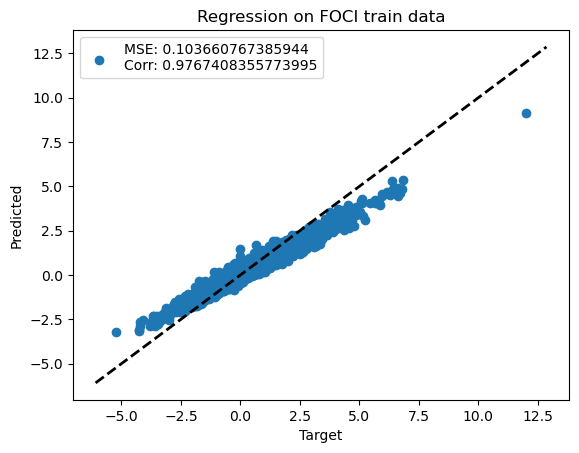

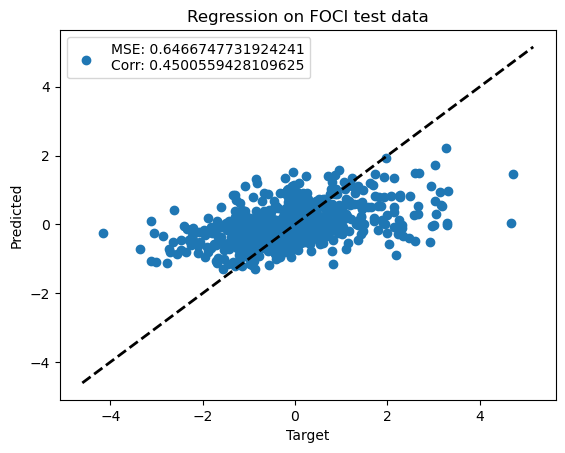

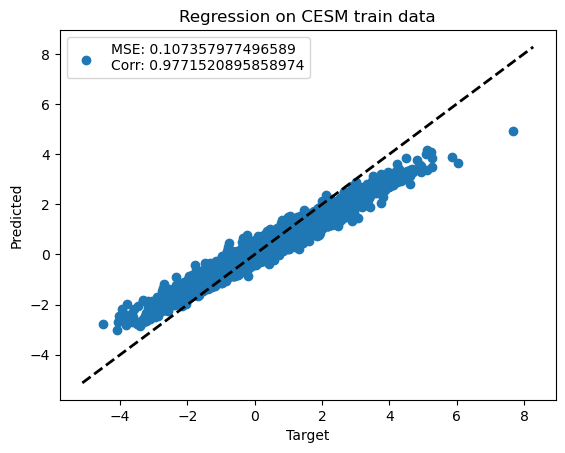

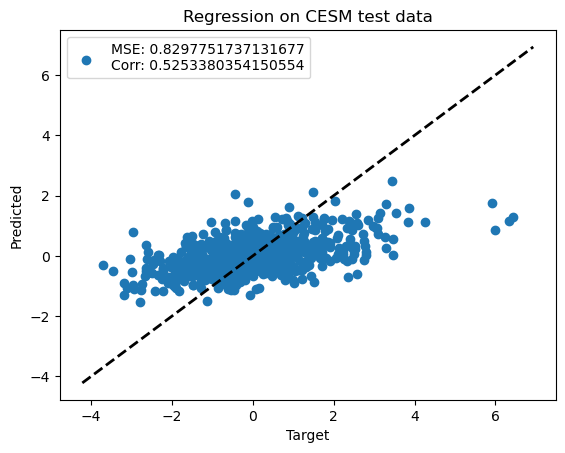

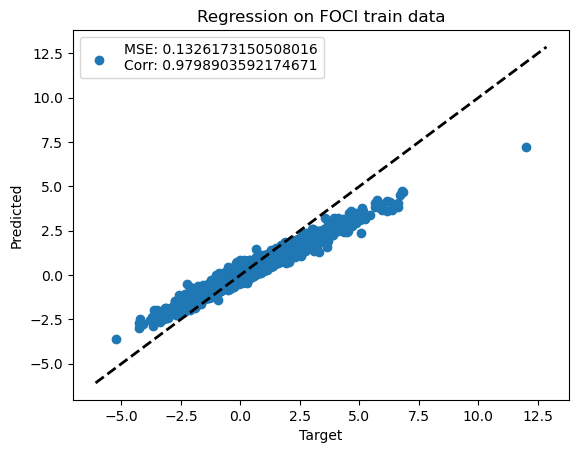

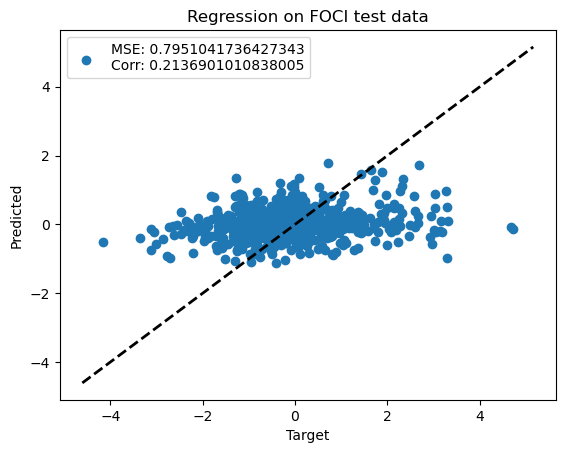

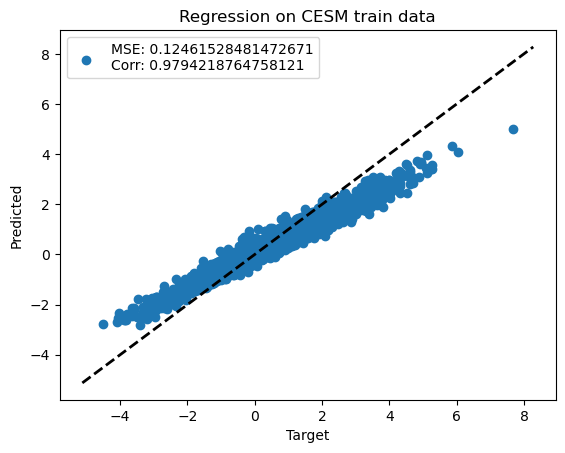

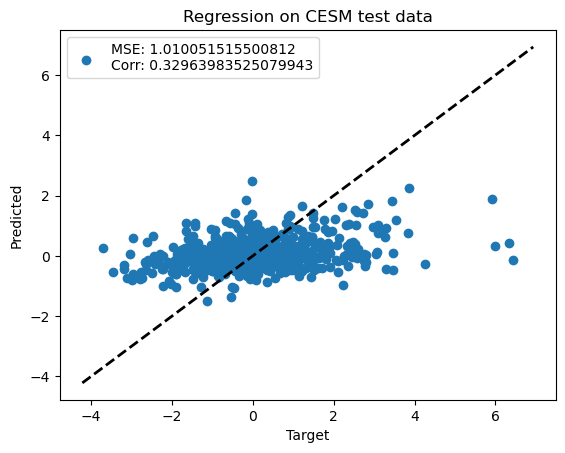

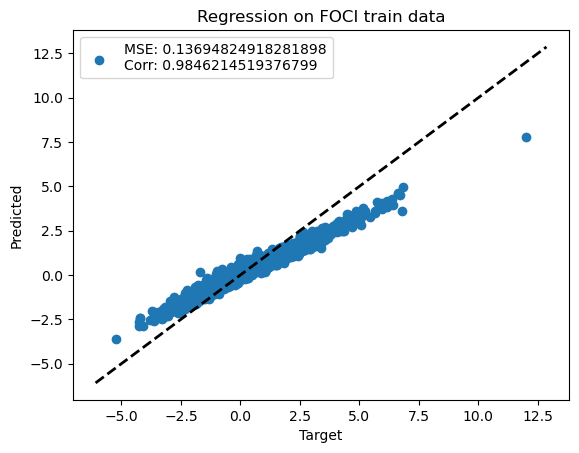

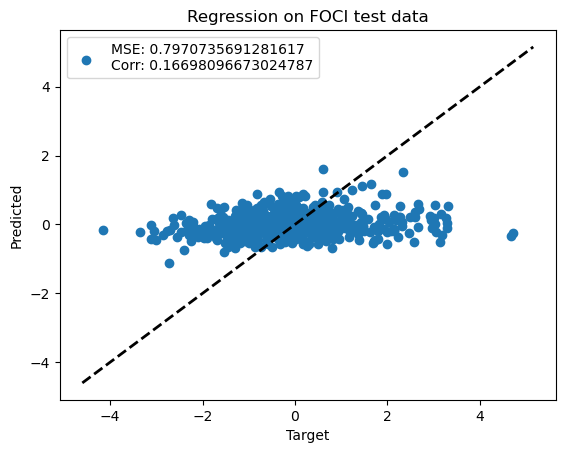

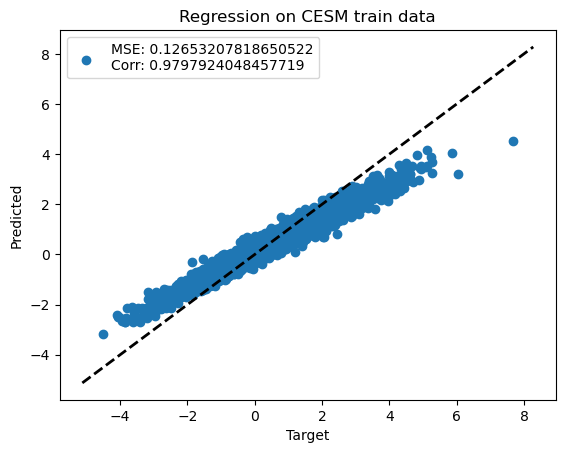

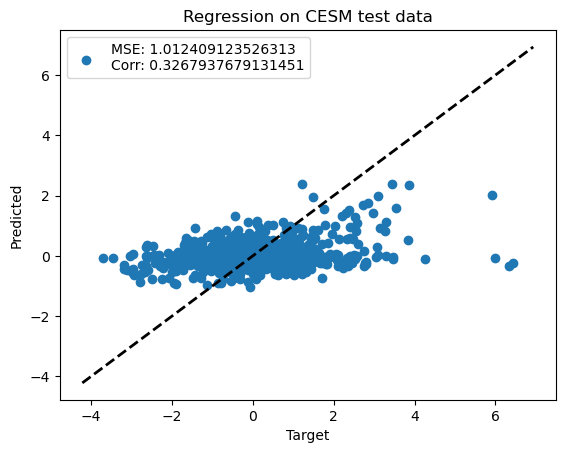

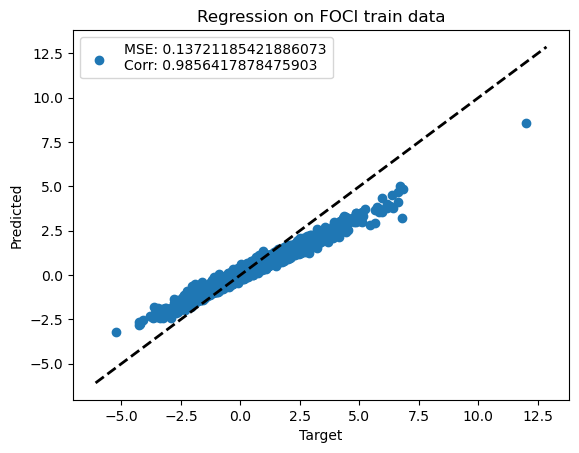

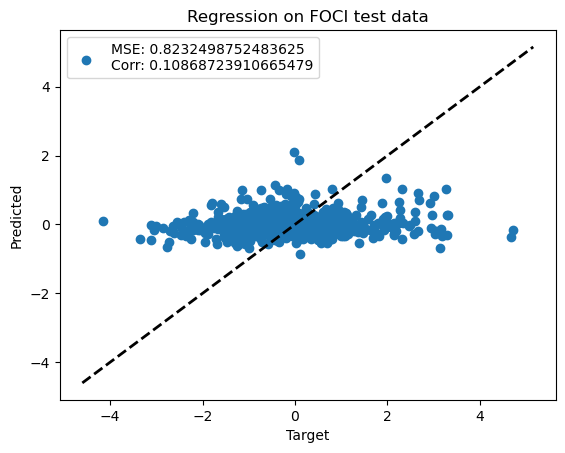

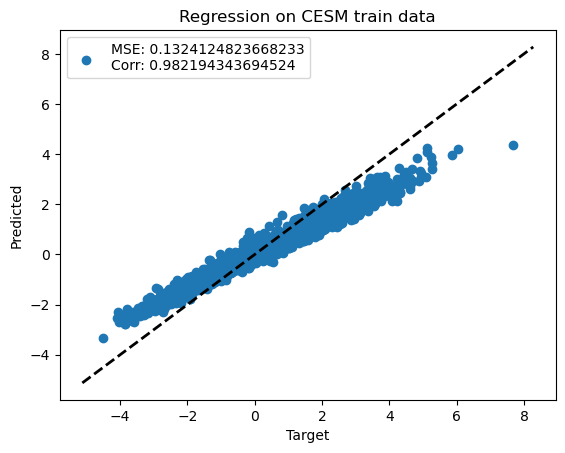

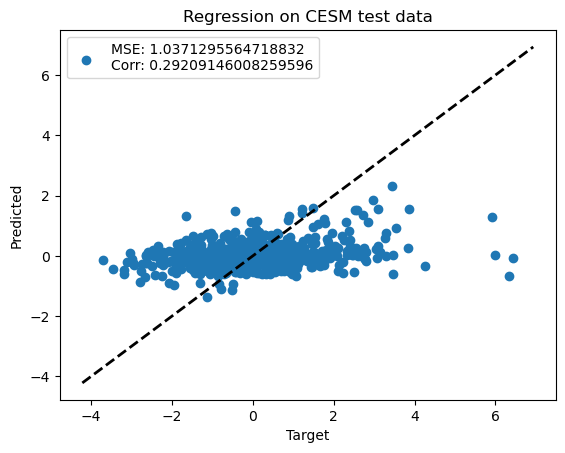

In [13]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
results_rfr = evaluate_for_leadtimes_sklearn(rfr, 'RandomForest')

In [14]:
combine_and_show_dicts([results_rfr])

Name  lead time  MSE FOCI  MSE CESM  Corr FOCI  Corr CESM
0  RandomForest          0  0.646675  0.829775   0.450056   0.525338
1  RandomForest          1  0.795104  1.010052   0.213690   0.329640
2  RandomForest          3  0.797074  1.012409   0.166981   0.326794
3  RandomForest          6  0.823250  1.037130   0.108687   0.292091

# Regression via adaboost

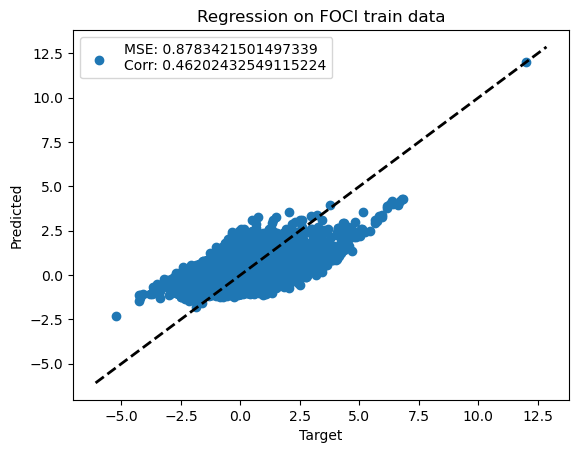

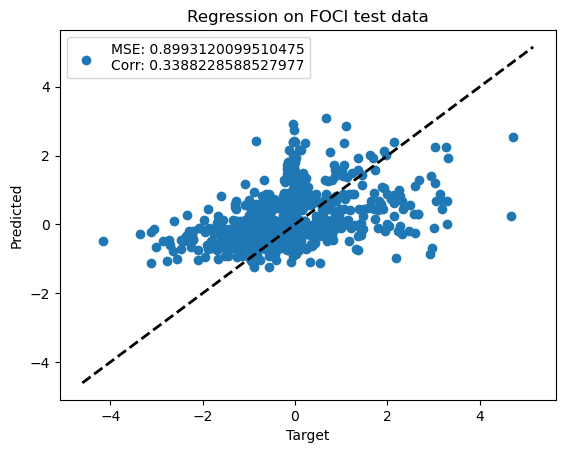

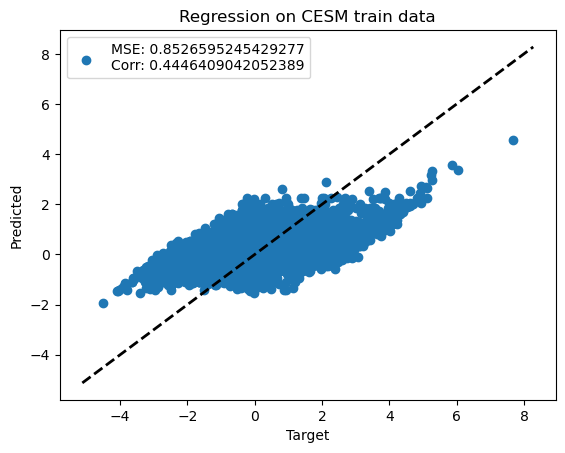

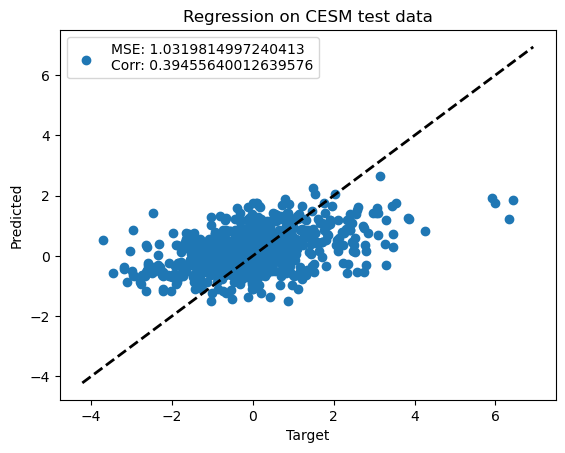

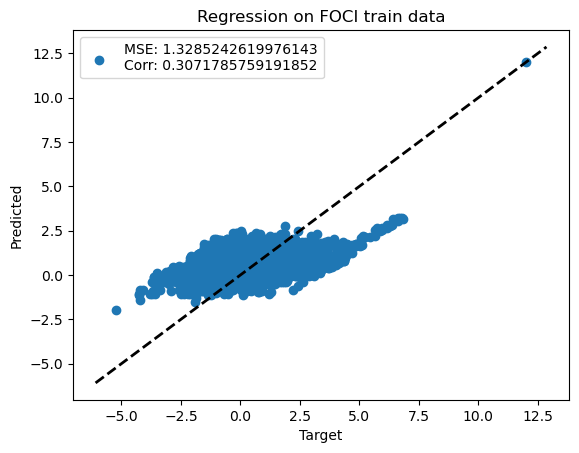

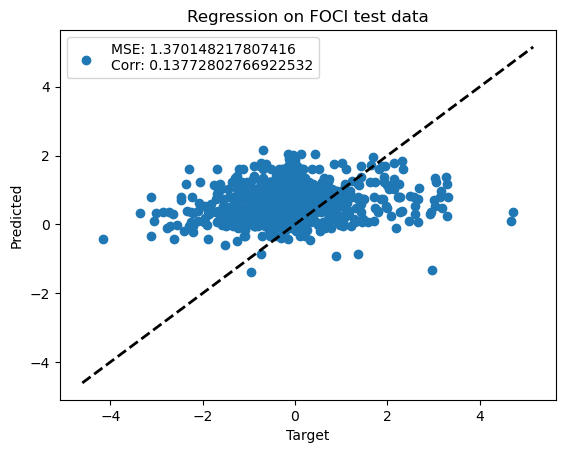

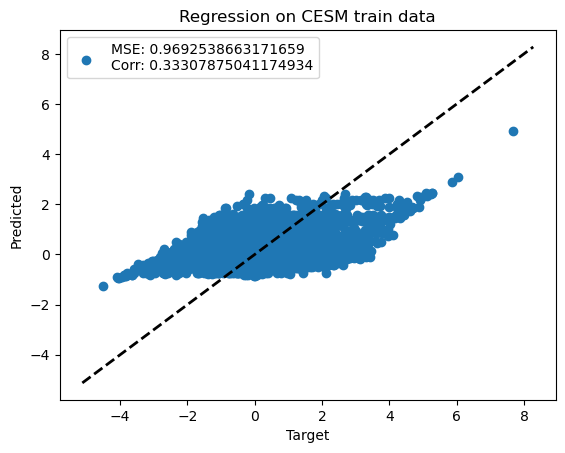

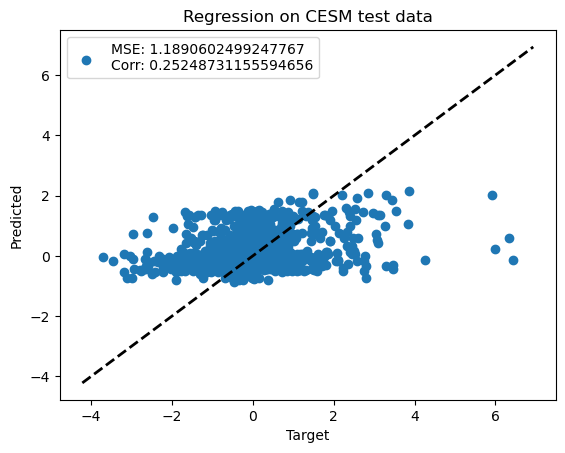

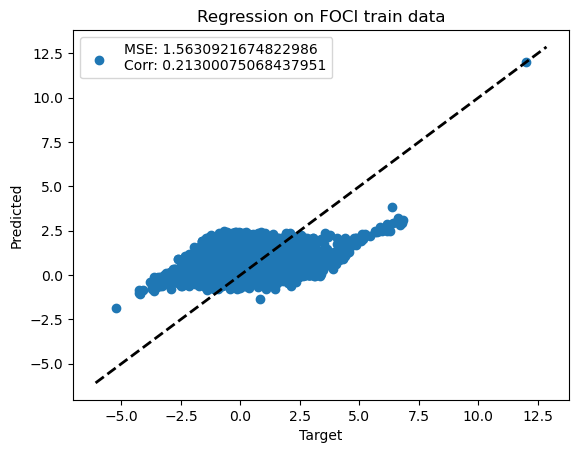

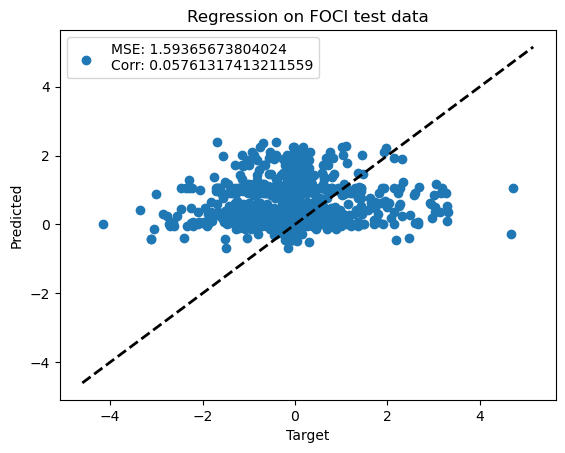

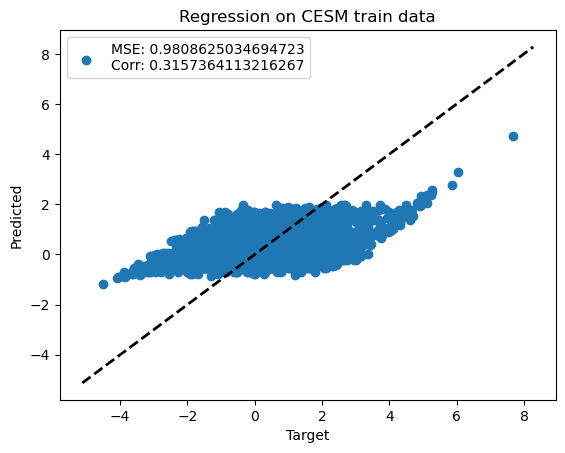

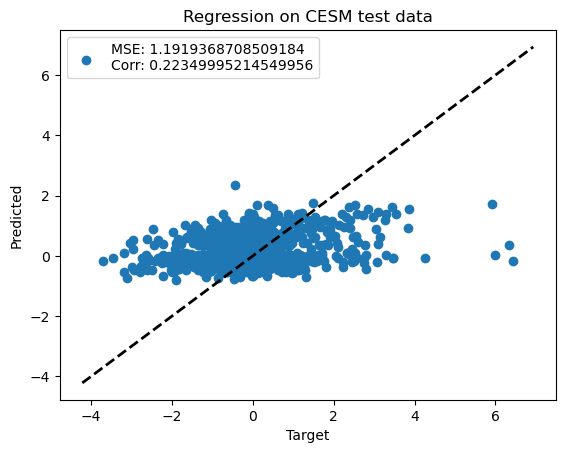

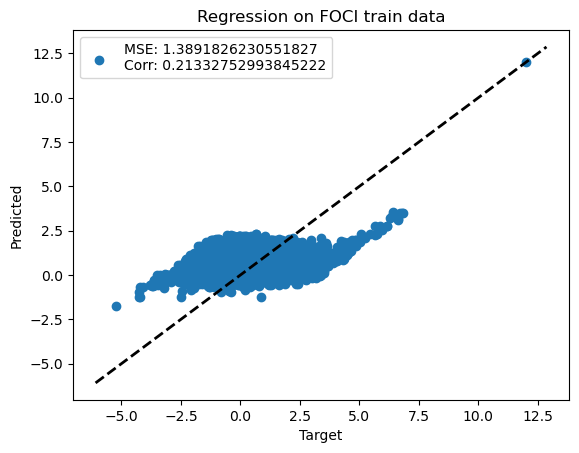

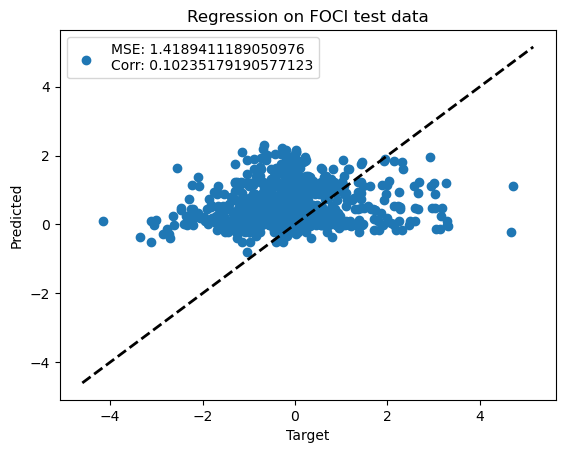

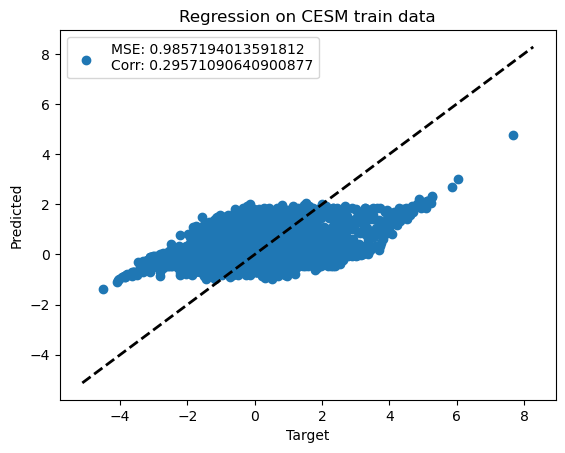

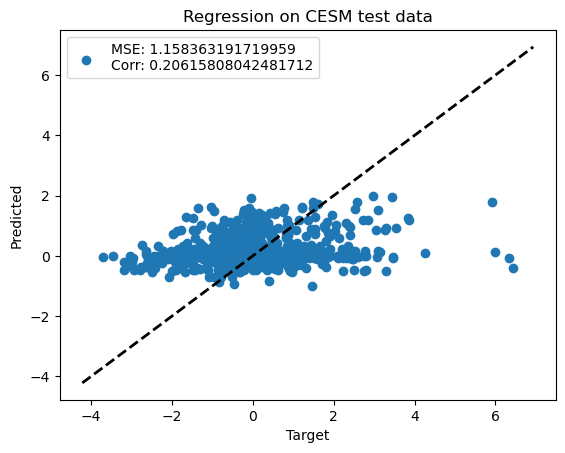

In [29]:
adaboost = AdaBoostRegressor(random_state=0, n_estimators=100, learning_rate=1)
results_ada = evaluate_for_leadtimes_sklearn(adaboost, 'adaboost')

In [30]:
#combine_and_show_dicts([results_ada])

df = pd.DataFrame(results_ada)
df.set_index('lead time', inplace=True, drop=True)
display(df)
df.to_csv('rf.csv')

Name  MSE FOCI  MSE CESM  Corr FOCI  Corr CESM
lead time                                                    
0          adaboost  0.899312  1.031981   0.338823   0.394556
1          adaboost  1.370148  1.189060   0.137728   0.252487
3          adaboost  1.593657  1.191937   0.057613   0.223500
6          adaboost  1.418941  1.158363   0.102352   0.206158

# Simple feed forward neural network

In [57]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, num_in):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_in, 8)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 4)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

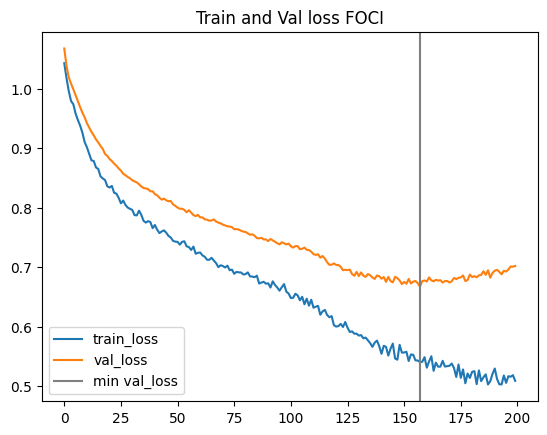

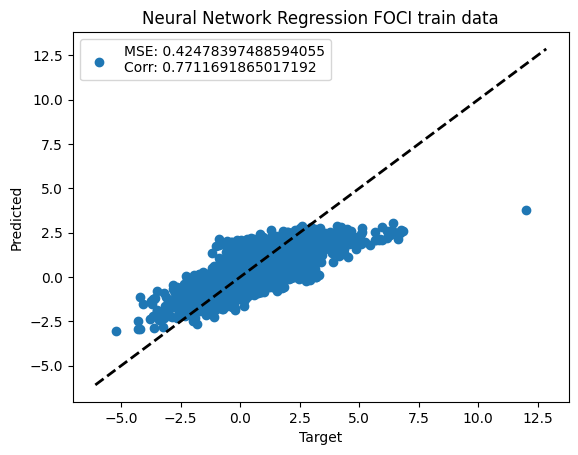

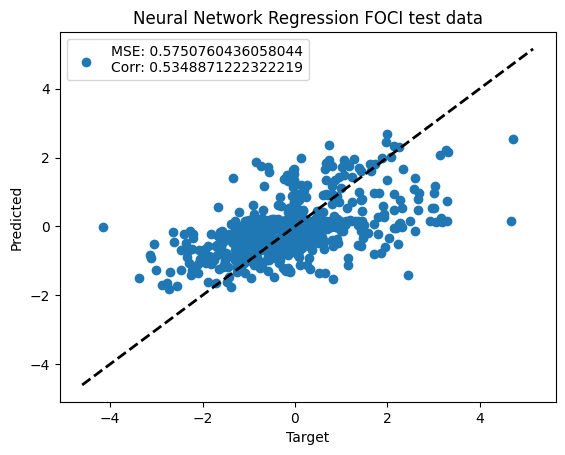

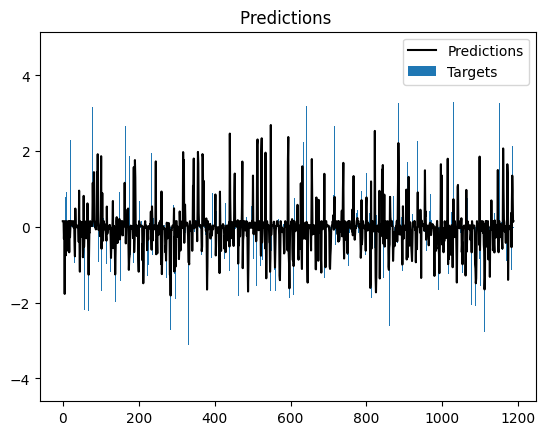

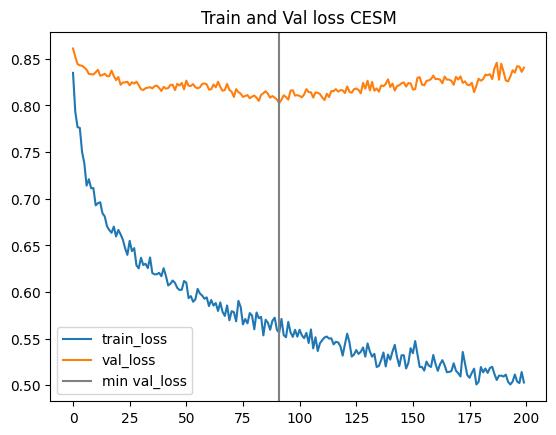

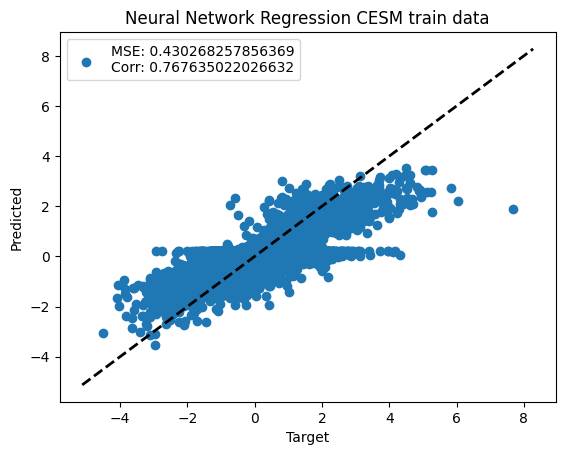

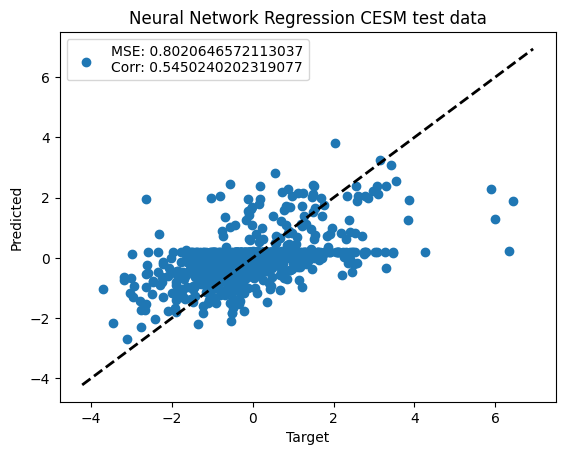

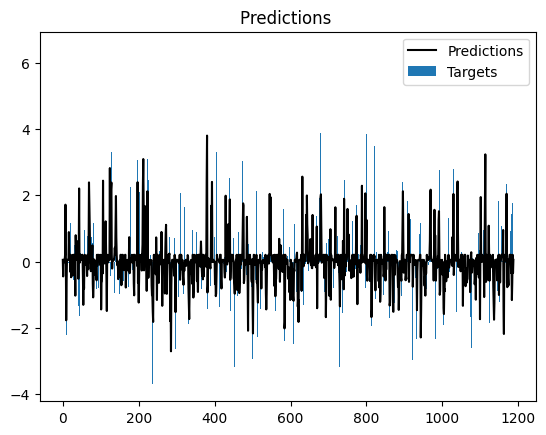

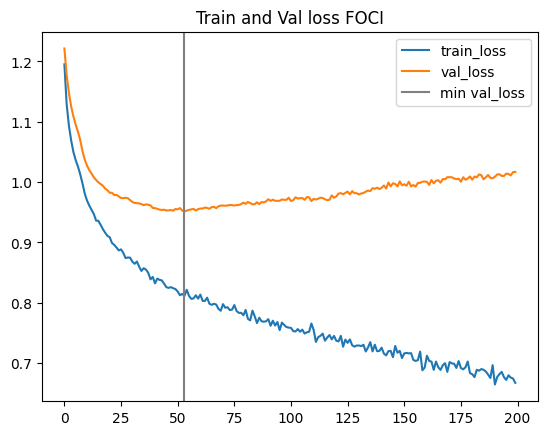

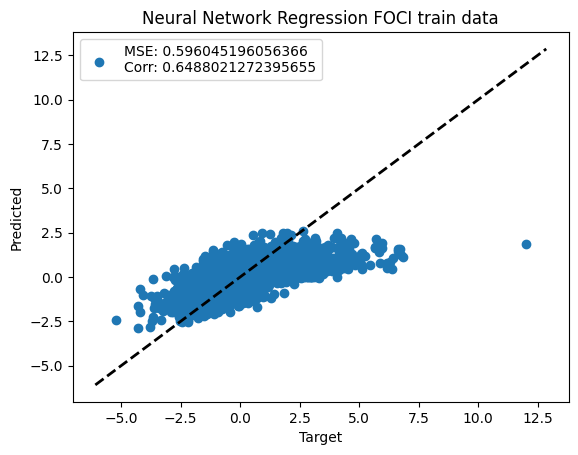

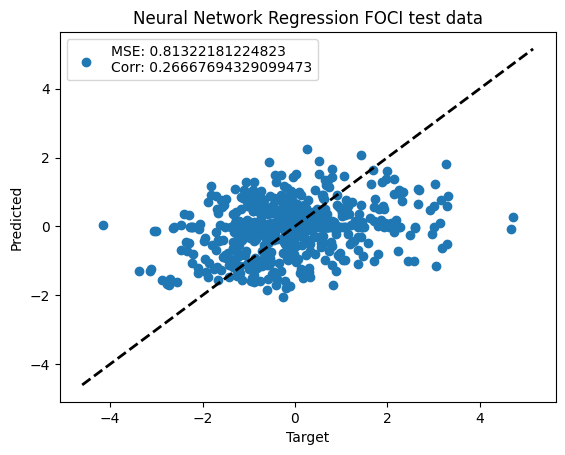

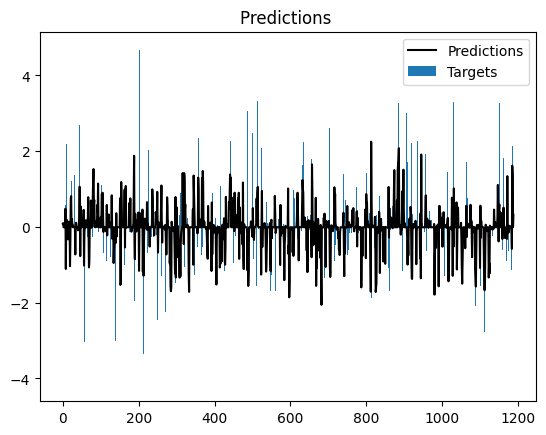

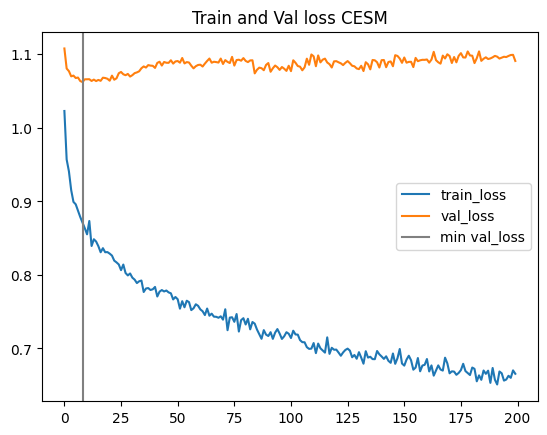

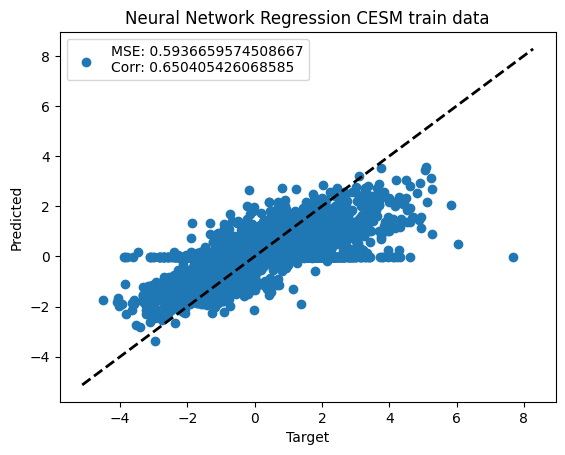

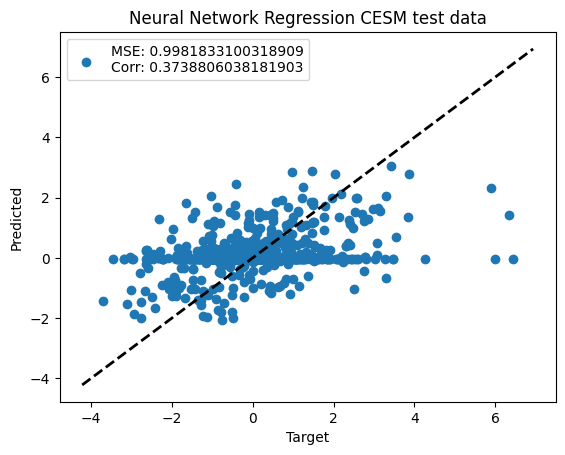

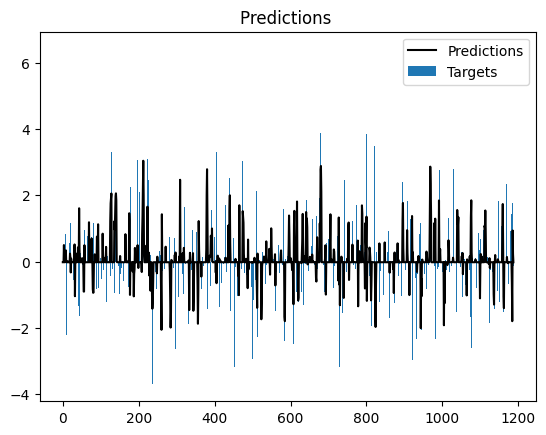

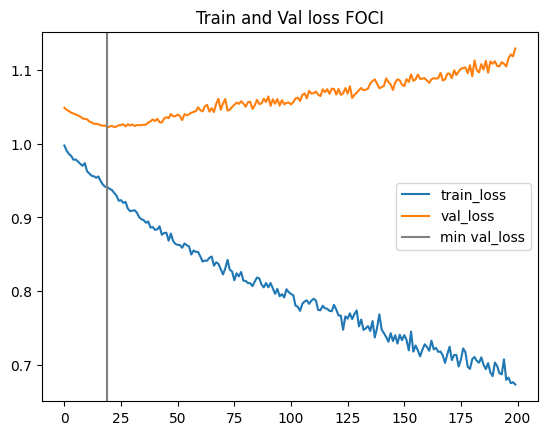

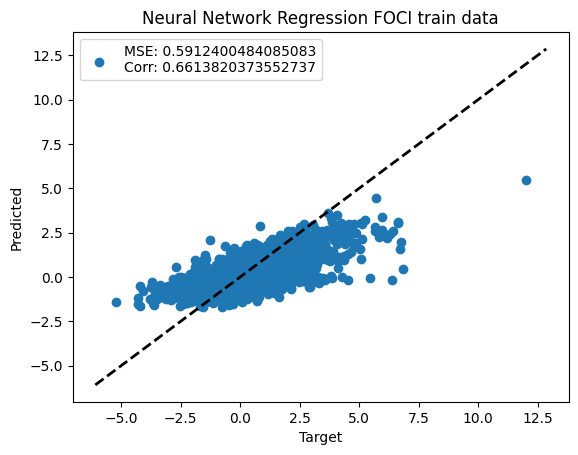

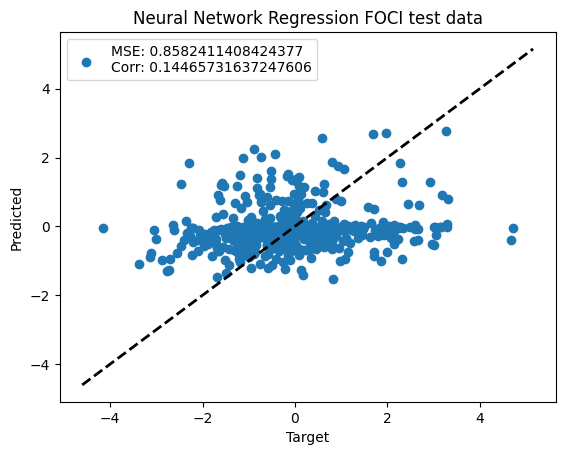

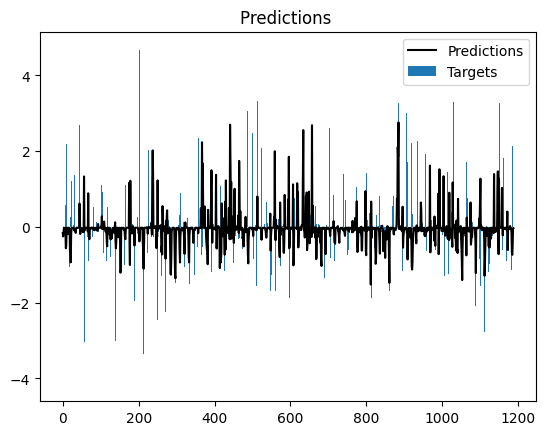

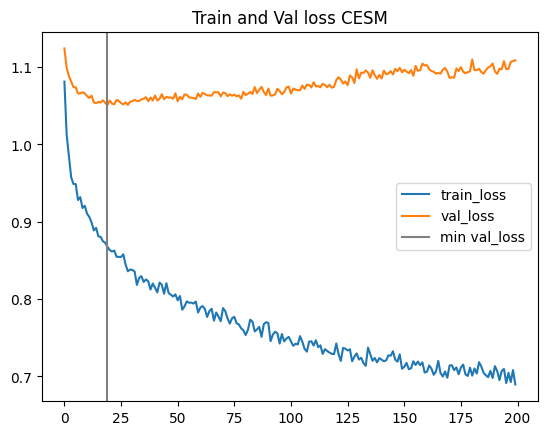

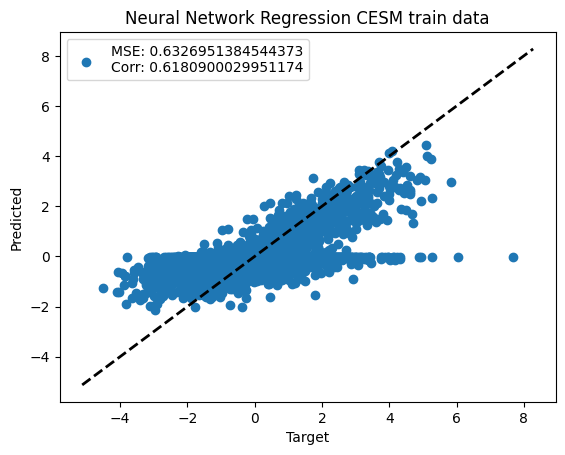

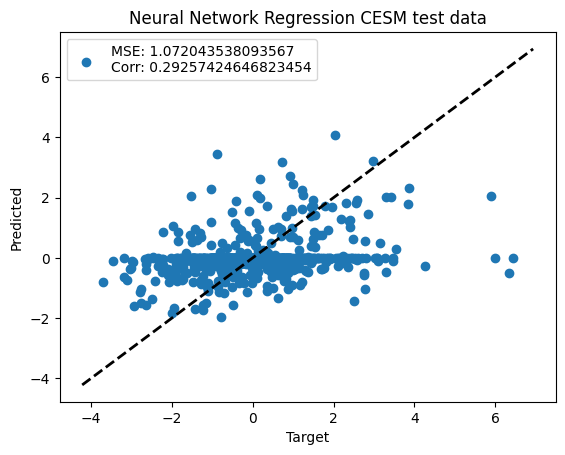

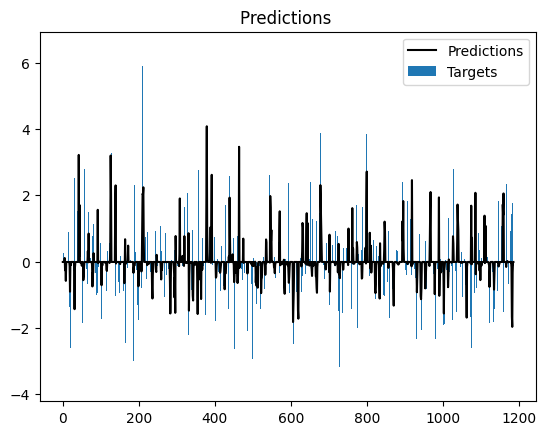

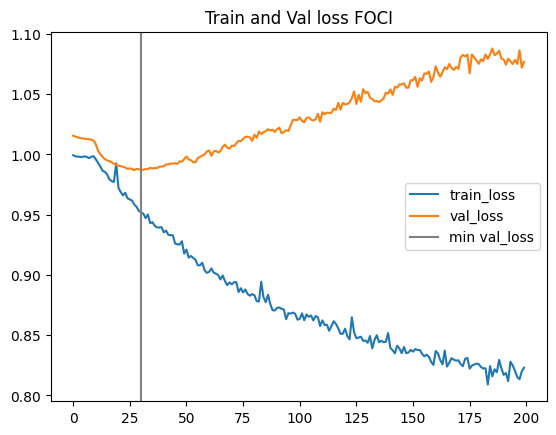

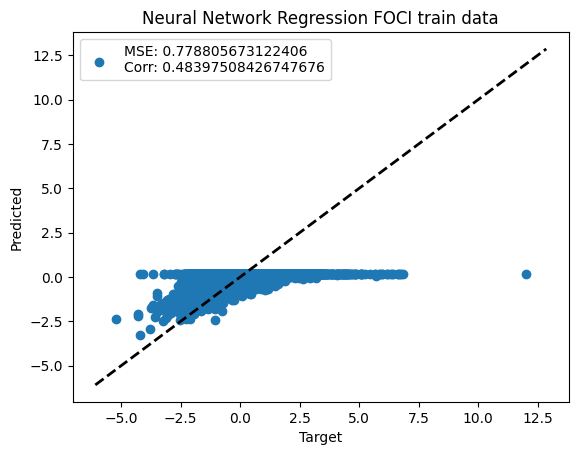

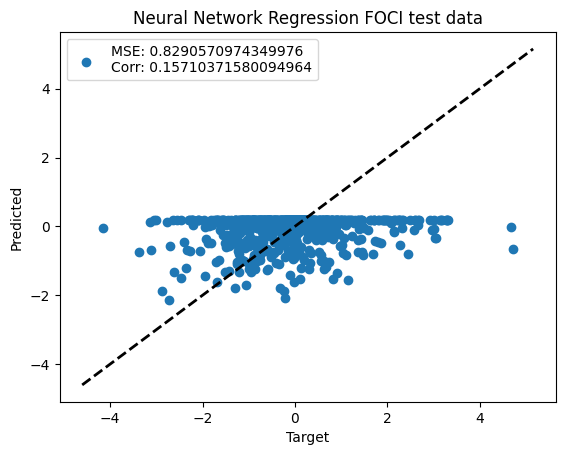

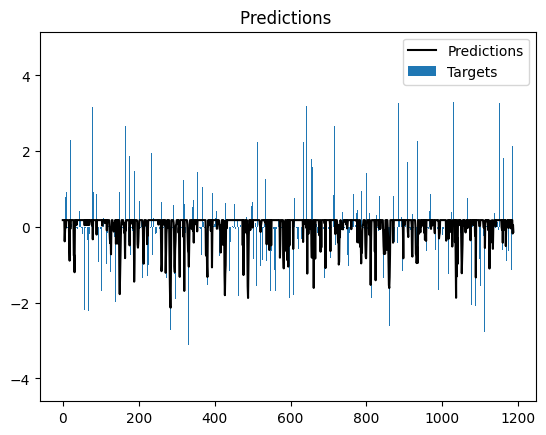

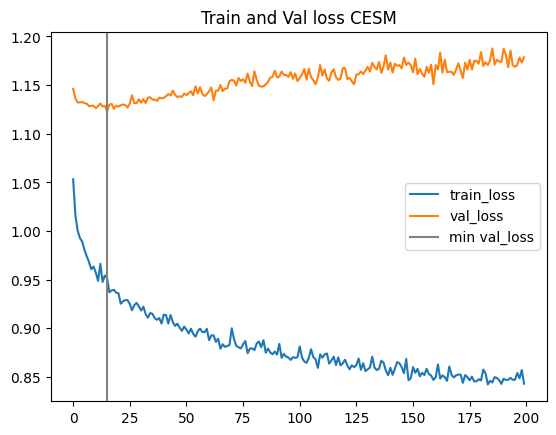

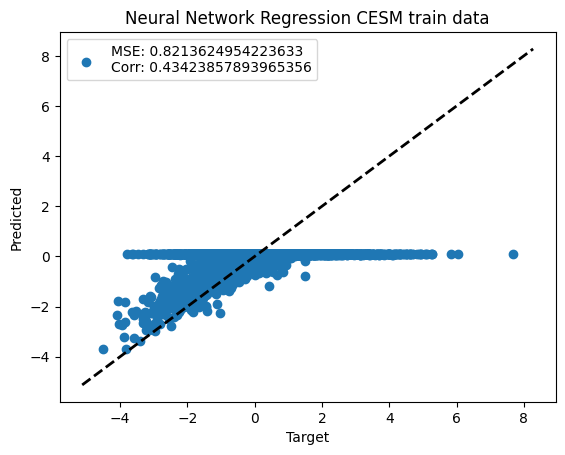

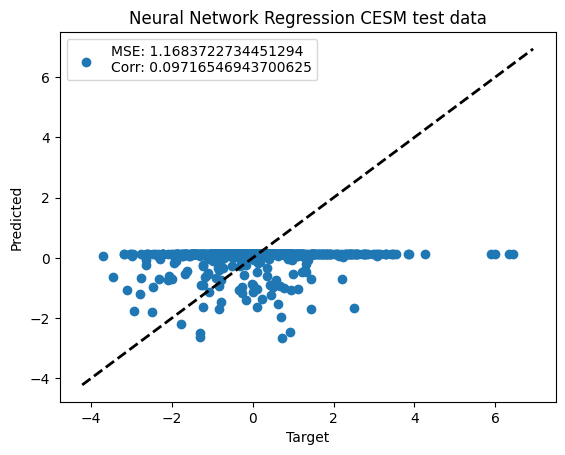

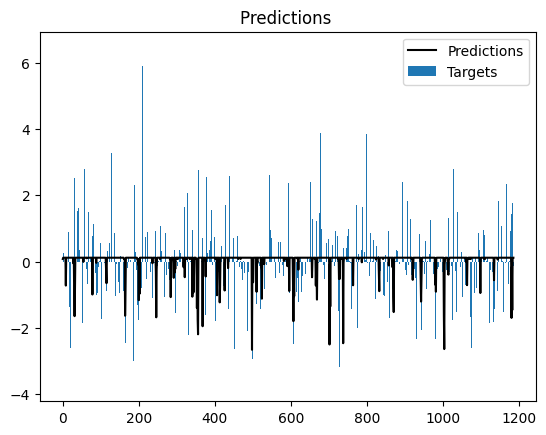

In [67]:
torch.manual_seed(0)
results_ff = evaluate_for_leadtimes(Net, 'FF Network', flatten_seq=True, seq_length=12, weight_decay=0.0001, num_epochs=200, learning_rate=0.0001)

In [69]:
combine_and_show_dicts([results_ff])

Name  lead time  MSE FOCI  MSE CESM  Corr FOCI  Corr CESM
0  FF Network          0  0.575076  0.802065   0.534887   0.545024
1  FF Network          1  0.813222  0.998183   0.266677   0.373881
2  FF Network          3  0.858241  1.072044   0.144657   0.292574
3  FF Network          6  0.829057  1.168372   0.157104   0.097165

# RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, num_in):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=num_in, hidden_size=8, num_layers=1, nonlinearity='relu', batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(8, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        x, _ = self.rnn(x, h0)
        x = x[:,-1,:]  # Get only final output
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
torch.manual_seed(0)
results_rnn = evaluate_for_leadtimes(RNN, 'RNN', flatten_seq=False, seq_length=12, num_epochs=100, learning_rate=0.001, weight_decay=0.00001)

In [ ]:
combine_and_show_dicts([results_rnn])

# LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_in):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_in, hidden_size=8, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(8, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [14]:
torch.manual_seed(0)
results_lstm = evaluate_for_leadtimes(LSTM, 'LSTM', flatten_seq=False, seq_length=12, num_epochs=200, learning_rate=0.001, weight_decay=0.01, lead_times=[6])

KeyboardInterrupt: 

In [ ]:
combine_and_show_dicts([results_lstm])

# CNN

In [ ]:
# in_channels = depth of kernel, where for each depth the kernel has its own set of weights
# out_channels = number of kernels that will be used
class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()

      # Results in 10 Feature maps of size (28-3)/1 + 1 = 26
      self.conv1 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=3, stride=1)
      # Results in 10 Feature maps of size 13
      self.pool1 = nn.MaxPool1d(2, 2)

      # Results in 20 feature maps of size 10
      self.conv2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
      # Results in 20 feature maps of size 5
      self.pool2 = nn.MaxPool1d(2, 2)

      # Fully connected layers taking the flattened input
      self.fc1 = nn.Linear(20*5, 10)
      self.fc2 = nn.Linear(10, 1)

      # relu
      self.relu = nn.ReLU()

    def forward(self, x):
      # First convolutional layer
      x = self.conv1(x)
      x = self.pool1(x)
      x = self.relu(x)

      # Second convolutional layer
      x = self.conv2(x)
      x = self.pool2(x)
      x = self.relu(x)

      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)

      return x

In [ ]:
# left out for now because i would have to do some stuff that takes a bit longer
#torch.manual_seed(0)
#results_cnn = evaluate_for_leadtimes(CNN, 'CNN', flatten_seq=False, seq_length=12, num_epochs=100, learning_rate=0.001, weight_decay=0.01)

# RNN with Attention

In [109]:
class RNN_A(nn.Module):
    def __init__(self, num_in):
        super(RNN_A, self).__init__()
        self.rnn = nn.RNN(input_size=num_in, hidden_size=16, num_layers=1, nonlinearity='relu', batch_first=True)
        self.attention = nn.MultiheadAttention(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        x, _ = self.rnn(x, h0)
        x = x[:,-1,:]
        x, _ = self.attention(x, x, x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

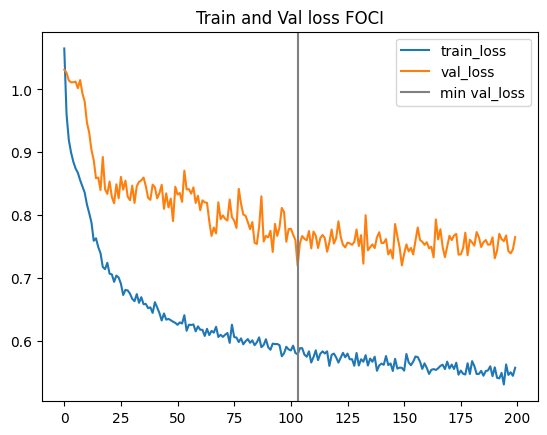

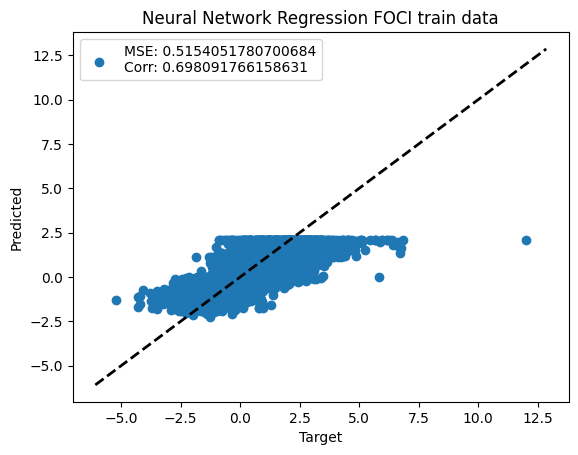

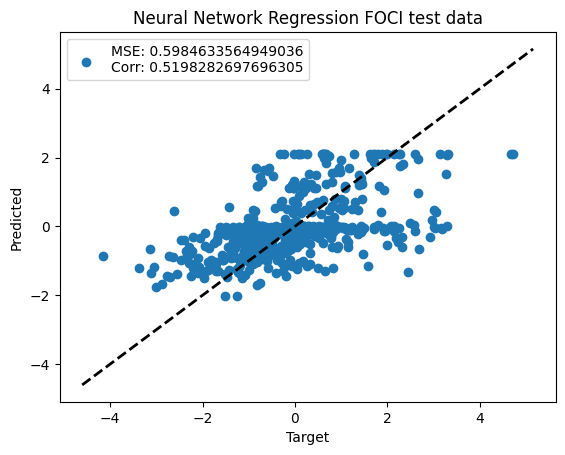

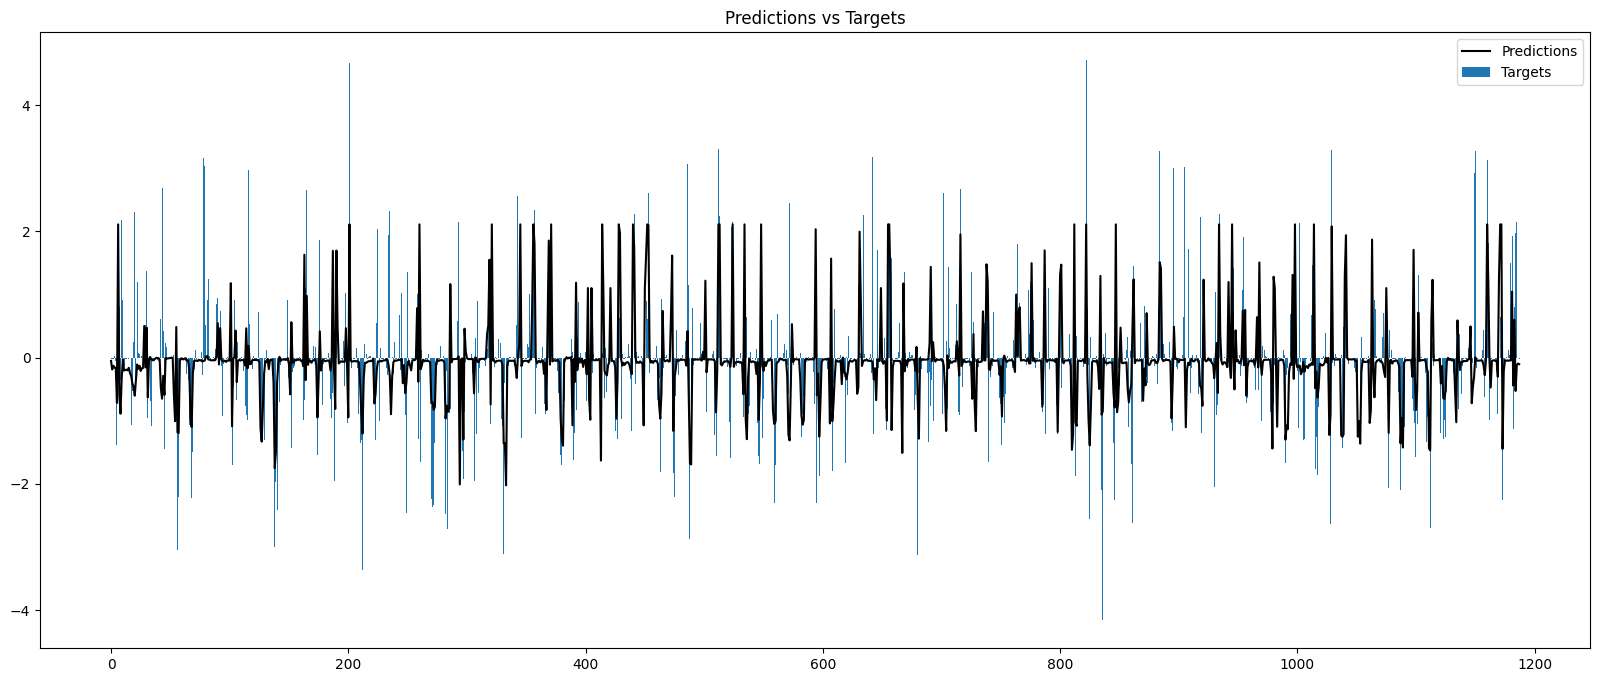

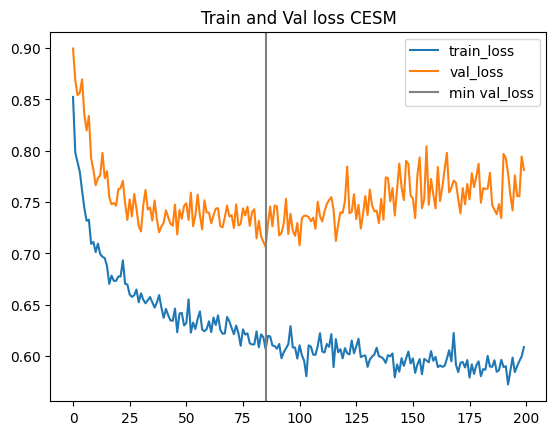

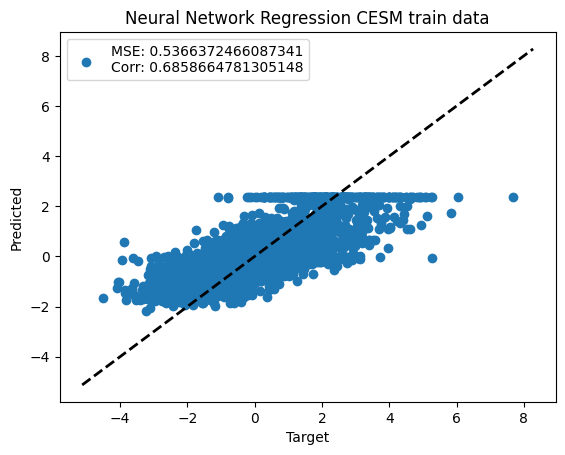

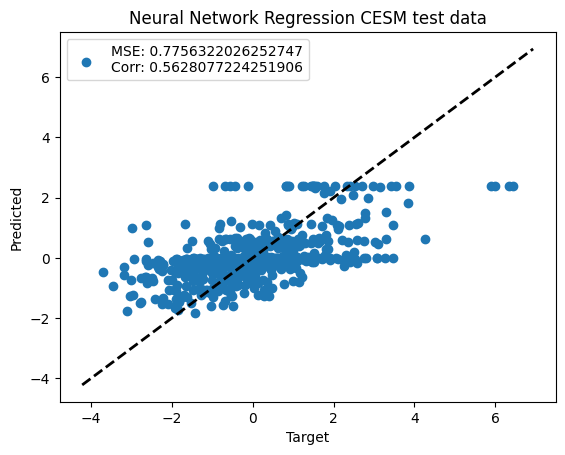

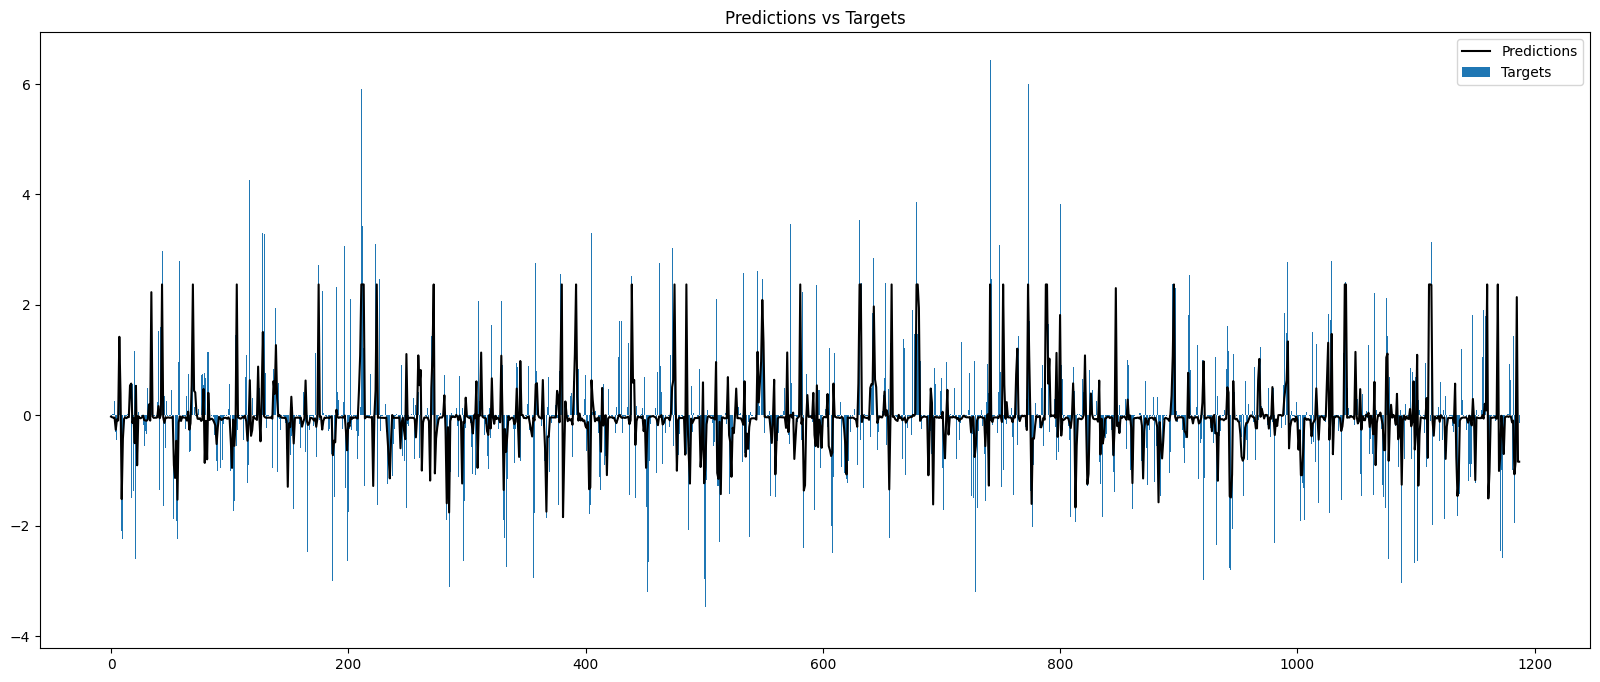

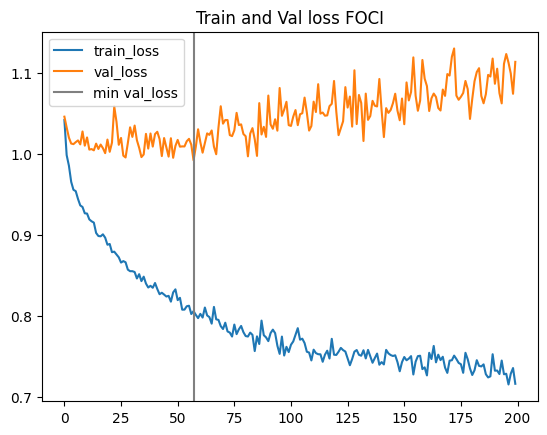

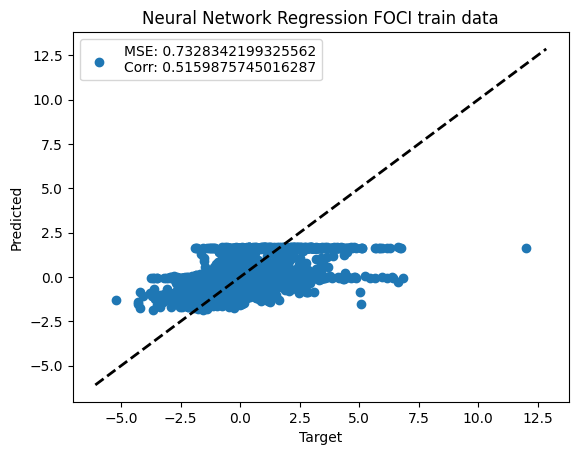

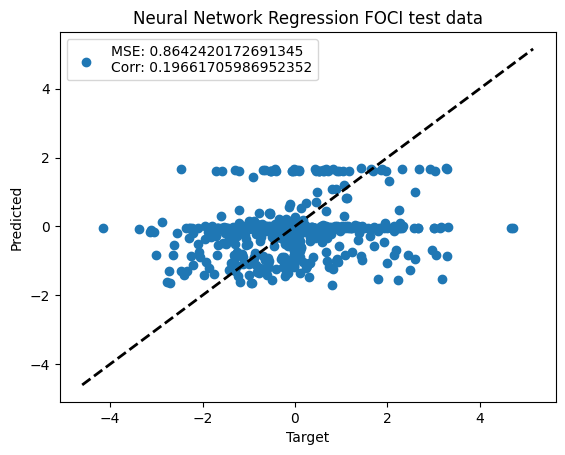

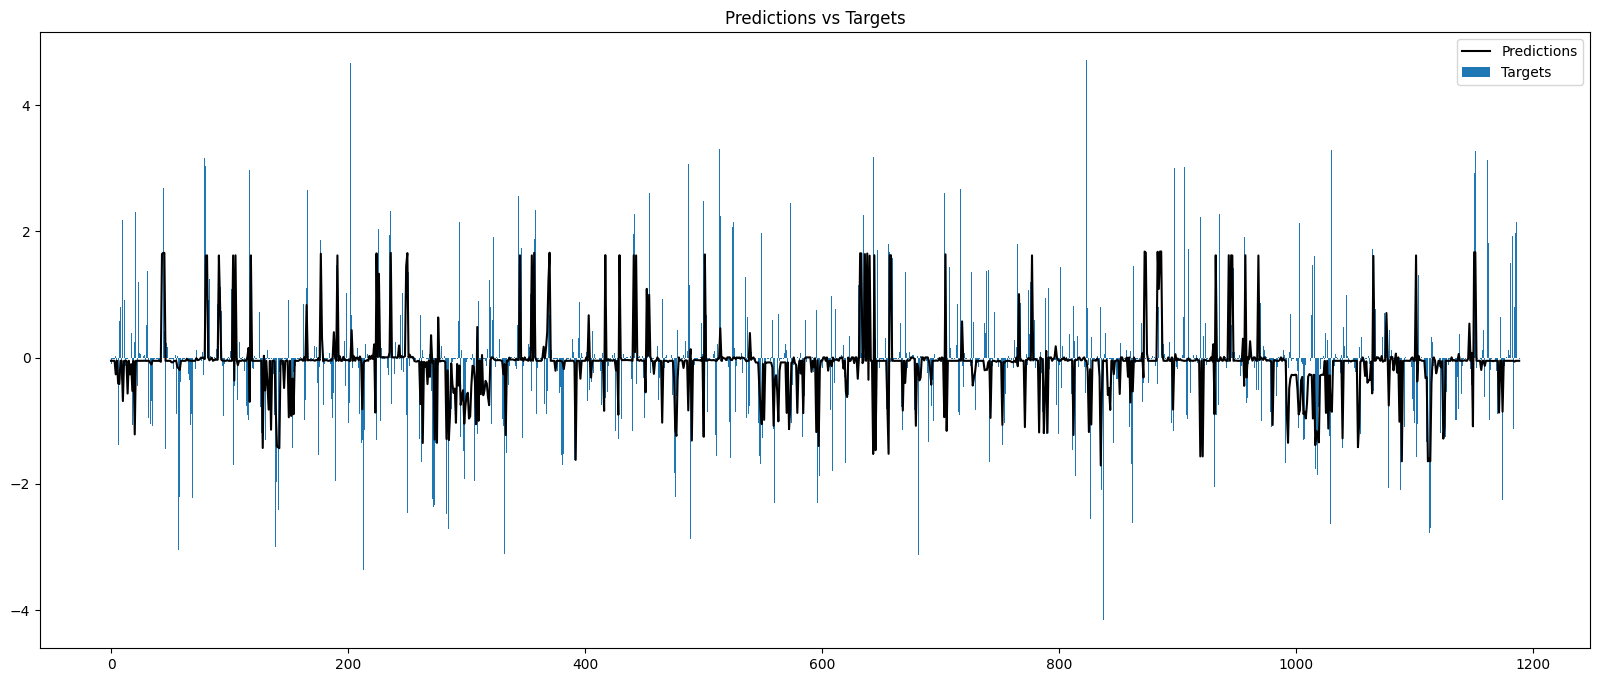

In [ ]:
torch.manual_seed(0)
results_rnn_attention = evaluate_for_leadtimes(RNN_A, 'Attention RNN', flatten_seq=False, seq_length=12, num_epochs=200, learning_rate=0.001)

In [ ]:
combine_and_show_dicts([results_rnn_attention])

# LSTM with Attention

In [ ]:
class LSTM_A(nn.Module):
    def __init__(self, num_in):
        super(LSTM_A, self).__init__()
        self.lstm = nn.LSTM(input_size=num_in, hidden_size=16, num_layers=1, batch_first=True)
        self.attention = nn.MultiheadAttention(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x, _ = self.attention(x, x, x)

        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3)
        x = self.fc4(x)

        return x

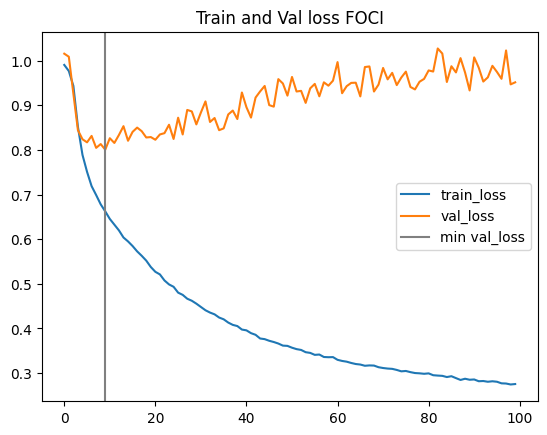

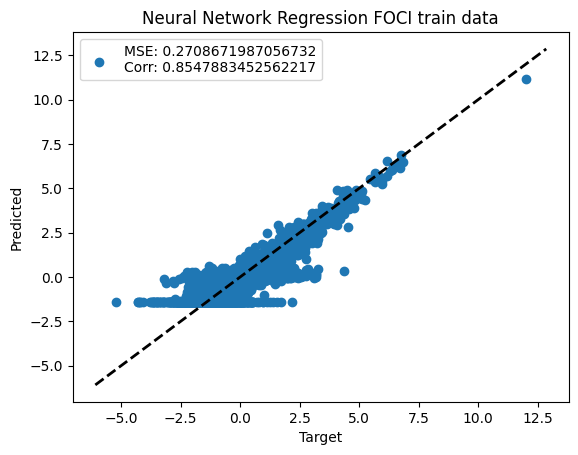

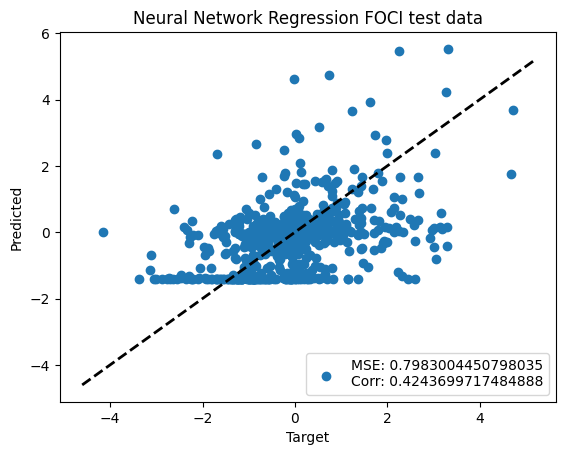

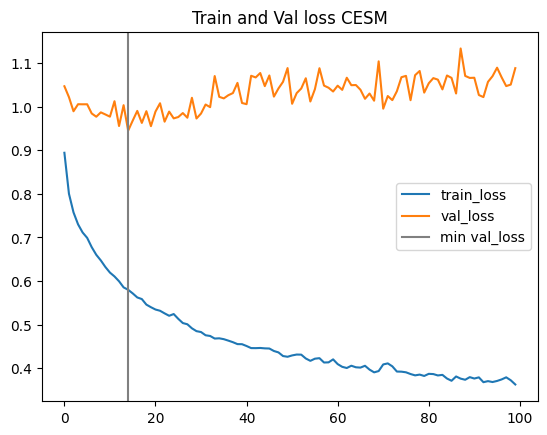

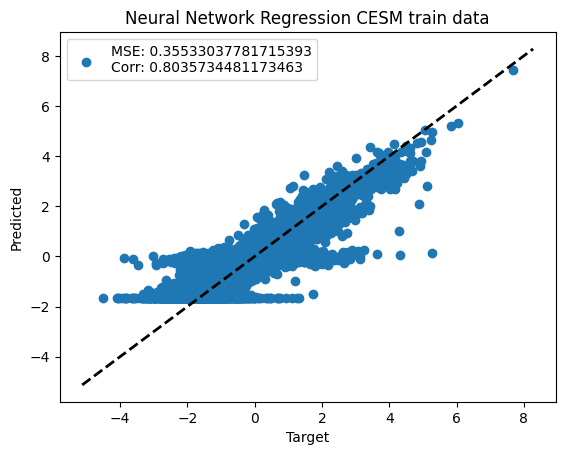

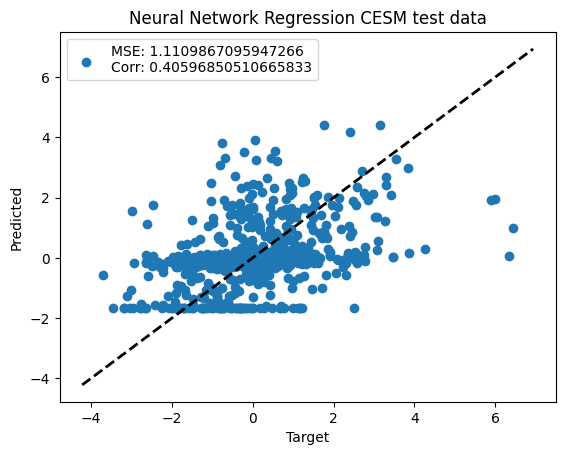

Name  lead time  MSE FOCI  MSE CESM  Corr FOCI  Corr CESM
0  Attention LSTM          0    0.7983  1.110987    0.42437   0.405969

In [ ]:
results_lstm_attention = evaluate_for_leadtimes(LSTM_A, 'Attention LSTM', flatten_seq=False, seq_length=12, lead_times=[0])
combine_and_show_dicts([results])

In [ ]:
all_results = []

combine_and_show_dicts(all_results)